In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [26]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
sys.path.append('../')
import Utils.utils as util
from importlib import reload
reload(util)

from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize

np.set_printoptions(threshold=np.inf) #print full arrays
from sklearn import linear_model

In [27]:
def split_patch(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    pixel_central = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    patch_sans_central = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((patch_sans_central, pixel_central))
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    #patch = patch.flatten()
    h = patch.shape[0]
    patch = np.reshape(patch, h*h*3)
    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def find_index_noisy_lines(label):
    """
    indexes = []
    for index, value in enumerate(label):
        if(value == -1):
            indexes.append(index)
    """
    label = np.array(label)
    indexes = np.where(label < 0)
    return indexes

def delete_all_indexes_from(dictionary, label):
    indexes = find_index_noisy_lines(label)
    dictionary = np.delete(dictionary, indexes , 0)
    label = np.delete(label, indexes , 0)
    
    return (dictionary, label)    

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h, clear_image):
    noisy_image_orig = np.array(noisy_image)
    
    #todo question: vérifier qu'il faut bien faire le lassocv pour trouver le alpha sur le clear?
        
    lassocv = linear_model.LassoCV()
    y, x = coord_noisy_pix[0]
    label = util.get_patch(x, y, h, noisy_image)
    label = list(convert_patch_into_vector(label))
    lassocv.fit(dictionary, label)
    alpha_ = lassocv.alpha_
    
    #alpha_ = 0.01
    
    print("alpha = ", alpha_)
    dictionary_full = np.array(dictionary)
       
    i = 0
    nbiter  = len(coord_noisy_pix)
    for y, x in coord_noisy_pix:
        if(i%10==0): print( i, " / ", nbiter)
        i = i + 1
        
        #print("Correction de x : ", x, " et y : ", y)
        patch = util.get_patch(x, y, h, noisy_image)
        label = list(convert_patch_into_vector(patch))
        
        #print("patch : ", patch)
        
        dictionary = np.array(dictionary_full)
        dictionary, label = delete_all_indexes_from(dictionary,label)

        #print("--- lasso regression ---")
        
        model = Lasso(fit_intercept=True,alpha=alpha_,positive=True)
        
        model.fit(dictionary, label)
        
        res = model.predict(dictionary_full)
        newPixel = util.get_centered_pixel(res, h)

        
        """
        coef = model.coef_.reshape((1,-1)) #poids
        sparse_coef_ = model.sparse_coef_
    
        print(sparse_coef_)
        print("coef shape : ", coef.shape)
        #print("sparse_coef_ shape : ", sparse_coef_.shape)
        print("nb patch not at zero: ", np.count_nonzero(sparse_coef_.toarray()), " / ", coef.shape[1])
        print("dictionary shape : ", dictionary_full.shape) 
        
        normalized_coefs = normalize(coef, norm='l1')
        #print("normalized_coefs shape = ", normalized_coefs)
        print("sum(normalized_coefs) = ", np.sum(normalized_coefs, axis=1))
        
        res = normalized_coefs*dictionary_full
        print("coef*dictionary shape= ",res.shape)
        
        resflat = np.sum(normalized_coefs*dictionary,axis=1)
        #print("resflat = ",resflat)
        
        print("sum(normalized_coefs*dictionary,axis=1) shape= ", resflat.shape)
        
        newPixel = util.get_centered_pixel(resflat, h)
        print("nouveau pixel : ", newPixel)
        print("")
        """
        #print("new pixel : ", newPixel)
        noisy_image[x][y] = newPixel
        
        #Test a supprimer
        _,clear_patches = util.get_patches(noisy_image, h, width, height)
        dictionary_full = convert_patches_into_training_set(clear_patches)
        print("shape : ", dictionary_full.shape)
        
        
        #util.display_im(noisy_image) #pour afficher toutes les images

    util.display_im(noisy_image_orig)
    util.display_im(noisy_image)

taille de l'image :  (256, 256, 3)
256  ,  256
nbclear: 2585


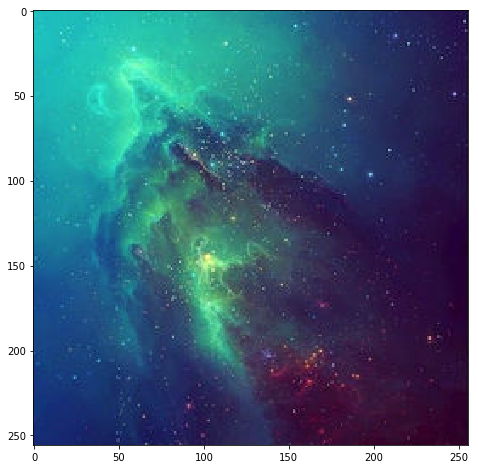

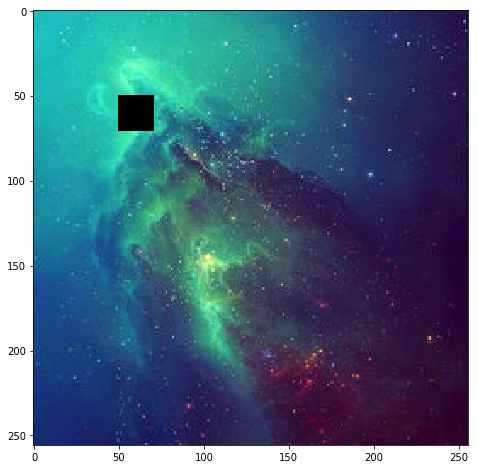

In [28]:
%matplotlib inline
img_matrice = util.read_im("Data/imgdataset/12.jpg")

print("taille de l'image : ", img_matrice.shape)

util.display_im(img_matrice)

#Taille des patchs
h=3 #nombre impair

noisy_image, deletepixels = util.delete_rect(img_matrice, 60, 60, 13, 13)
#display_im(noisy_image)

width = img_matrice.shape[1]
height = img_matrice.shape[0]

print(width," , ", height)

util.display_im(noisy_image)

_,clear_patches = util.get_patches(noisy_image, h, width, height)

nbclear = np.shape(clear_patches)[0]
print("nbclear:", nbclear)

In [29]:
training = convert_patches_into_training_set(clear_patches)
print(training.shape)

(75, 2585)


In [30]:
a = np.array([[[1, 'a'], [2, 'a'], [3, 'a']], [[4, 'a'], [5, 'a'], [6, 'a']], [[7, 'a'], [8, 'a'], [9, 'a']]])

In [31]:
def spyral_transformation(a):
    out = []
    while (a.size):
        out.append(a[0])
        a = np.rot90(np.delete(a, 0, 0))
    return np.concatenate(out)


alpha =  0.01
0  /  441
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
10  /  441
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
20  /  441
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
30  /  441
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
40  /  441
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
50  /  441
shape :  (75, 2585)
shape :  (75, 2585)
shape :  (75, 2585)
shape

shape :  (75, 2598)
shape :  (75, 2598)
shape :  (75, 2598)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
400  /  441
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
shape :  (75, 2599)
410  /  441
shape :  (75, 2599)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
420  /  441
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2600)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
430  /  441
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
shape :  (75, 2601)
440  /  441
shape :  (75, 2601)


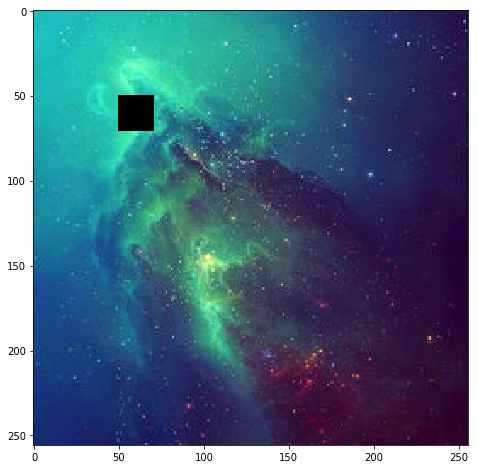

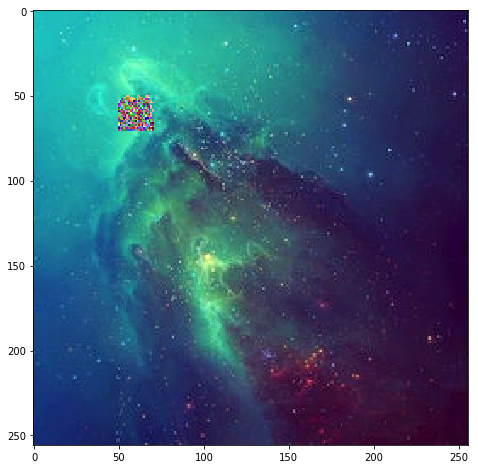

In [32]:
deletepixels_transformed = spyral_transformation(np.array(deletepixels))

inpaint_image(noisy_image, training, deletepixels_transformed, h, img_matrice)